In [1]:
%load_ext watermark
%watermark

Last updated: 2022-12-19T22:24:42.741986-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.7.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import pandas as pd

import numpy as np

import seaborn as sns

from ipywidgets import interact, FloatSlider, IntSlider, fixed

from IPython.display import display

from scipy import stats

import pickle

from datetime import datetime

import matplotlib.pyplot as plt

import os

import queue

import threading

from concurrent.futures import ThreadPoolExecutor

import itertools

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.python.platform import build_info as build
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop

from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Dropout
from keras.callbacks import TensorBoard
from keras.constraints import maxnorm

sns.set(font_scale=0.7)

# Resume

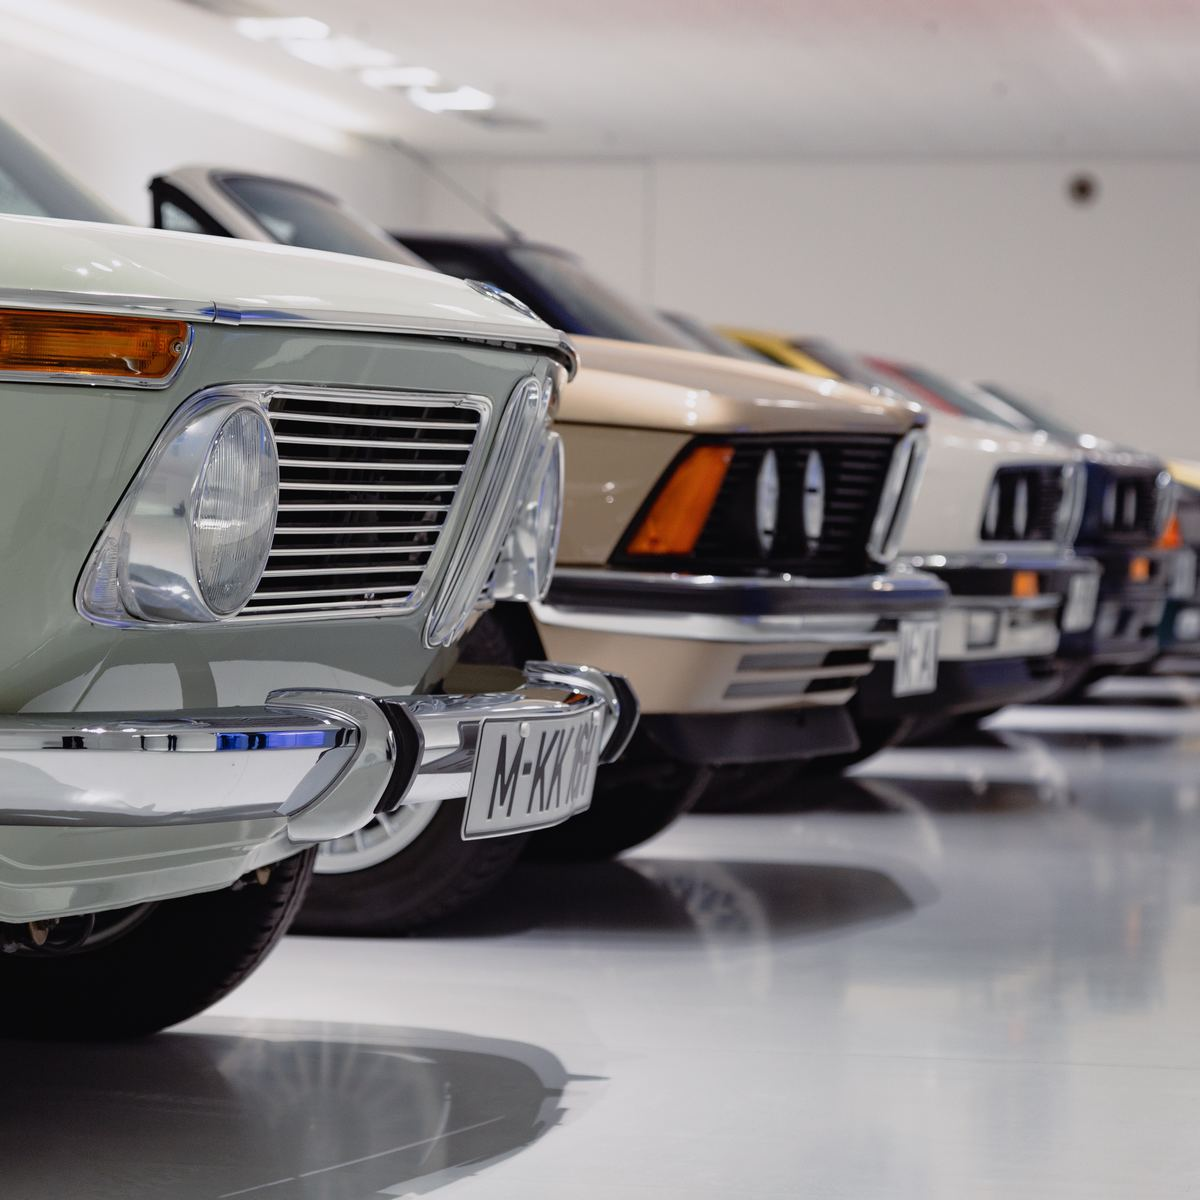

# Data Collection

In [3]:
df = pd.read_csv('_resources/vehicles_us.csv', parse_dates=['date_posted'])
df.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         51525 non-null  int64         
 1   model_year    47906 non-null  float64       
 2   model         51525 non-null  object        
 3   condition     51525 non-null  object        
 4   cylinders     46265 non-null  float64       
 5   fuel          51525 non-null  object        
 6   odometer      43633 non-null  float64       
 7   transmission  51525 non-null  object        
 8   type          51525 non-null  object        
 9   paint_color   42258 non-null  object        
 10  is_4wd        25572 non-null  float64       
 11  date_posted   51525 non-null  datetime64[ns]
 12  days_listed   51525 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(6)
memory usage: 5.1+ MB


# Data Wrangling

In [5]:
#

In [6]:
target_column = 'price'

# Data Visualization

In [7]:
def update_datatypes_columns():
    numeric_features = df.select_dtypes(include=np.number).columns.to_list()

    continuous_features = df.select_dtypes(include=float).columns.to_list()

    discrete_features = df.select_dtypes(include=int).columns.to_list()

    categorical_features = df.select_dtypes(
        include='category').columns.to_list()

    object_features = df.select_dtypes(include='object').columns.to_list()

    bool_features = df.select_dtypes(include=bool).columns.to_list()

    date_time_features = df.select_dtypes(
        include=np.datetime64).columns.to_list()

    time_delta_features = df.select_dtypes(
        include=np.timedelta64).columns.to_list()

    display({'numeric_features': numeric_features, 'continuous_features': continuous_features,
             'discrete_features': discrete_features, 'categorical_features': categorical_features,
             'object_features': object_features, 'bool_features': bool_features,
             'date_time_features': date_time_features, 'time_delta_features': time_delta_features})

    return numeric_features, continuous_features, discrete_features, categorical_features, \
        object_features, bool_features, date_time_features, time_delta_features


numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

{'numeric_features': ['price',
  'model_year',
  'cylinders',
  'odometer',
  'is_4wd',
  'days_listed'],
 'continuous_features': ['model_year', 'cylinders', 'odometer', 'is_4wd'],
 'discrete_features': ['price', 'days_listed'],
 'categorical_features': [],
 'object_features': ['model',
  'condition',
  'fuel',
  'transmission',
  'type',
  'paint_color'],
 'bool_features': [],
 'date_time_features': ['date_posted'],
 'time_delta_features': []}

## Statistical Summary

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         51525 non-null  int64         
 1   model_year    47906 non-null  float64       
 2   model         51525 non-null  object        
 3   condition     51525 non-null  object        
 4   cylinders     46265 non-null  float64       
 5   fuel          51525 non-null  object        
 6   odometer      43633 non-null  float64       
 7   transmission  51525 non-null  object        
 8   type          51525 non-null  object        
 9   paint_color   42258 non-null  object        
 10  is_4wd        25572 non-null  float64       
 11  date_posted   51525 non-null  datetime64[ns]
 12  days_listed   51525 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(6)
memory usage: 5.1+ MB


In [9]:
df.describe()

,price,model_year,cylinders,odometer,is_4wd,days_listed
count,51525.000000,47906.000000,46265.000000,43633.000000,25572.0,51525.00000
mean,12132.464920,2009.750470,6.125235,115553.461738,1.0,39.55476
std,10040.803015,6.282065,1.660360,65094.611341,0.0,28.20427
min,1.000000,1908.000000,3.000000,0.000000,1.0,0.00000
25%,5000.000000,2006.000000,4.000000,70000.000000,1.0,19.00000
50%,9000.000000,2011.000000,6.000000,113000.000000,1.0,33.00000
75%,16839.000000,2014.000000,8.000000,155000.000000,1.0,53.00000
max,375000.000000,2019.000000,12.000000,990000.000000,1.0,271.00000


## Correlation

### Dispersion Diagram

In [10]:
@interact(hue=[None] + categorical_features + bool_features,
          size=[None] + numeric_features,
          n_samples=IntSlider(value=10000, min=10000, max=50000, step=1000))
def _(hue, size, n_samples):

    if hue != None and len(df[hue].unique()) > 20:
        print(f'Too many categories: {hue}={df[hue].unique()}')
        return

    _df = df.sample(n=n_samples, replace=False, random_state=23)

    sns.pairplot(data=_df, hue=hue, size=size, diag_kind='hist')

    plt.show()

interactive(children=(Dropdown(description='hue', options=(None,), value=None), Dropdown(description='size', o…

In [11]:
@interact(x=numeric_features,
          y=numeric_features,
          hue=[None] + categorical_features + bool_features,
          size=[None] + numeric_features,
          style=[None] + categorical_features + bool_features,
          alpha=FloatSlider(value=1, min=.1, max=1, step=.1),
          show=fixed(True), file_name=fixed(''))
def my_relplot(x, y, hue, size, style, alpha, show, file_name):

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    if style != None and len(df[style].unique()) > 50:
        if show == True:
            print(f'Too many categories: {style}={df[style].unique()}')

        return

    chart = sns.relplot(data=df, x=x, y=y, hue=hue, size=size,
                        style=style, alpha=alpha, height=6)

    plt.title(f'{x} vs {y}', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Dropdown(description='x', options=('price', 'model_year', 'cylinders', 'odometer', 'is_4…

In [12]:
@interact(x=numeric_features,
          y=categorical_features + bool_features,
          hue=[None] + categorical_features + bool_features,
          orient=['v', 'h'],
          n_samples=IntSlider(value=1000, min=1000, max=50000, step=1000),
          show=fixed(True), file_name=fixed(''))
def my_swarmplot(x, y, hue, orient, n_samples, show, file_name):

    plt.rcParams['figure.figsize'] = (10, 6)

    if y == None:
        print('No existen variables categóricas o booleanas.')
        return

    if len(df[y].unique()) > 50:
        if show == True:
            print(f'Too many categories: {y}={df[y].unique()}')

        return

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    _df = df.sample(n=n_samples, replace=True, random_state=23)

    if orient == 'v':
        x, y = y, x

    chart = sns.swarmplot(data=_df, x=x, y=y, hue=hue, orient=orient, size=3)

    plt.title(f'{y} by {x}', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Dropdown(description='x', options=('price', 'model_year', 'cylinders', 'odometer', 'is_4…

### Pearson Correlation

In [13]:
@interact(show=fixed(True), file_name=fixed(''))
def my_pearson(show, file_name):

    plt.rcParams['figure.figsize'] = (8, 8)

    matrix = df.corr(method='pearson', numeric_only=True)
    chart = sns.heatmap(data=matrix, annot=True, square=True, center=0)
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45, horizontalalignment='right')

    plt.title('Pearson Diagram', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## Distributions

### Histogram

In [14]:
@interact(col=numeric_features,
          normal=False,
          stat=['count', 'frequency', 'probability', 'percent', 'density'],
          cumulative=False,
          hue=[None] + categorical_features + bool_features,
          kde=False,
          show=fixed(True), file_name=fixed(''))
def my_histplot(col, normal, stat, cumulative, hue, kde, show, file_name):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
                           gridspec_kw={'width_ratios': [1, .4]})

    # ax1 -----------------------------------------------------------------------------------

    if normal == False:
        if hue != None and len(df[hue].unique()) > 50:
            if show == True:
                print(f'Too many categories: {hue}={df[hue].unique()}')

            plt.close()
            return

        chart = sns.histplot(data=df, ax=ax[0], x=col, hue=hue, stat=stat,
                             multiple='stack', cumulative=cumulative, kde=kde)
        chart.set(title='Histogram')
    else:
        try:
            # Valores de la media (mu) y desviación típica (sigma) de los datos
            mu, sigma = stats.norm.fit(data=df[col])

            chart = sns.histplot(data=df, ax=ax[0], x=col, stat='density')

            # Valores teóricos de la normal en el rango observado
            x_hat = np.linspace(min(df[col]), max(df[col]), num=100)
            y_hat = stats.norm.pdf(x_hat, mu, sigma)

            ax[0].plot(x_hat, y_hat, 'r', linewidth=2, label='normal')
            ax[0].legend()
        except Exception as e:
            chart = sns.histplot(data=df, ax=ax[0], x=col, stat=stat)
            print('ax_0 error:', e)

    # ax2 -----------------------------------------------------------------------------------

    try:
        fig = sm.qqplot(df[col], fit=True, line='q', alpha=0.4, lw=2, ax=ax[1])
    except Exception as e:
        print('ax_1 error:', e)

    # ---------------------------------------------------------------------------------------

    if show == False:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()
        return

    kurtosis, skew = stats.kurtosis(df[col]), stats.skew(df[col])
    kurtosis, skew = round(kurtosis, 2), round(skew, 2)

    if skew < -1 or skew > 1:
        print(f'- La distribución está muy sesgada (skew={skew}).')
    elif -1 <= skew < -0.5 or 0.5 < skew <= 1:
        print(f'- La distribución está moderadamente sesgada (skew={skew}).')
    elif -0.5 <= skew <= 0.5:
        print(f'- La distribución es aproximadamente simétrica (skew={skew}).')

    if kurtosis < -0.5:
        print(
            f'- La distribución platicúrtica (kurtosis={kurtosis}), ', end='')
        print('existe una baja concentración de los valores en torno a su media.')
    if kurtosis > 0.5:
        print(f'- La distribución leptocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una gran concentración de los valores en torno a su media.')
    if -0.5 <= kurtosis <= 0.5:
        print(f'- La distribución mesocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una concentración normal de los valores en torno a su media.')

    plt.show()

interactive(children=(Dropdown(description='col', options=('price', 'model_year', 'cylinders', 'odometer', 'is…

In [15]:
@interact(x=numeric_features,
          y=numeric_features,
          hue=[None] + categorical_features + bool_features,
          kind=['scatter', 'kde', 'hist', 'hex', 'reg', 'resid'],
          show=fixed(True), file_name=fixed(''))
def my_jointplot(x, y, hue, kind, show, file_name):

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    chart = sns.jointplot(data=df, x=x, y=y, hue=hue, kind=kind, height=6)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Dropdown(description='x', options=('price', 'model_year', 'cylinders', 'odometer', 'is_4…

### Box - Violin Plot

In [16]:
@interact(col=[None] + numeric_features,
          violin=False,
          orient=['v', 'h'],
          show=fixed(True), file_name=fixed(''))
def my_boxplot(col, violin, orient, show, file_name):

    plt.rcParams['figure.figsize'] = (10, 6)

    if violin:
        chart = sns.violinplot(data=df, x=col, orient=orient)
        plt.title('Violin Plot', fontsize=12)
    else:
        chart = sns.boxplot(data=df, x=col, orient=orient)
        plt.title('Box Plot', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Dropdown(description='col', options=(None, 'price', 'model_year', 'cylinders', 'odometer…

In [17]:
@interact(x=categorical_features + bool_features,
          y=numeric_features,
          hue=[None] + bool_features,
          violin=False,
          split=False,
          orient=['v', 'h'],
          show_points=False,
          show=fixed(True), file_name=fixed(''))
def my_violinplot(x, y, hue, violin, split, orient, show_points, show, file_name):

    if x == None:
        print('No existen variables categóricas o booleanas.')
        return

    if len(df[x].unique()) > 50:
        if show == True:
            print(f'Too many categories: {x}={df[x].unique()}')

        return

    x_org = x
    if orient == 'h':
        x, y = y, x

    if show_points == True:
        chart = sns.stripplot(data=df, x=x, y=y, color='.3', size=3)

    plt.rcParams['figure.figsize'] = (10, 6)

    if violin:
        chart = sns.violinplot(x=x, y=y, data=df, hue=hue,
                               split=split, orient=orient)
        plt.title(f'Violin Plot by {x_org}', fontsize=12)
    else:
        chart = sns.boxplot(x=x, y=y, data=df, hue=hue, orient=orient)
        plt.title(f'Box Plot by {x_org}', fontsize=12)

    sns.despine(offset=10, trim=True)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Dropdown(description='x', options=(), value=None), Dropdown(description='y', options=('p…

## Contingency Table

In [18]:
@interact(index=categorical_features + bool_features,
          columns=categorical_features + bool_features,
          values=numeric_features,
          annot=True,
          agg_func=['count', 'mean', 'median', 'sum', 'std', 'probability'],
          show=fixed(True), file_name=fixed(''))
def my_contingency(index, columns, values, annot, agg_func, show, file_name):

    plt.rcParams['figure.figsize'] = (8, 8)

    if index == None:
        print('No existen variables categóricas.')
        return

    if index == columns:
        sns.displot(data=df, x=index)
        plt.show()
        return

    if len(df[index].unique()) > 50:
        if show == True:
            print(f'Too many categories: {index}={df[index].unique()}')

        return

    if len(df[columns].unique()) > 50:
        if show == True:
            print(f'Too many categories: {columns}={df[columns].unique()}')

        return

    agg_func_aux = 'count' if agg_func == 'probability' else agg_func
    contingency_table = df.pivot_table(index=index, columns=columns, values=values,
                                       aggfunc=agg_func_aux,
                                       fill_value=0).dropna(axis=0, how='all')

#     display(contingency_table)

    if agg_func == 'probability':
        contingency_table = contingency_table.astype(float).div(contingency_table.sum(axis=1),
                                                                axis=0)
        fmt = '.2%'
    else:
        fmt = 'g'

    chart = sns.heatmap(contingency_table, annot=annot, fmt=fmt, square=False)
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45, horizontalalignment='right')

    if agg_func == 'count':
        plt.title(f'Contingency Table ({agg_func})', fontsize=12)
    else:
        plt.title(f'Contingency Table ({agg_func} {values})', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Dropdown(description='index', options=(), value=None), Dropdown(description='columns', o…

## Statistics

In [19]:
@interact(x=categorical_features + bool_features,
          y=numeric_features,
          hue=[None] + categorical_features + bool_features,
          estimator=['mean', 'count', 'median', 'sum', 'std'],
          kind=['bar', 'strip', 'box', 'violin', 'boxen', 'point'],
          orient=['v', 'h'],
          show=fixed(True), file_name=fixed(''))
def my_catplot(x, y, hue, estimator, kind, orient, show, file_name):

    if x == None:
        print('No existen variables categóricas.')
        return

    if len(df[x].unique()) > 50:
        if show == True:
            print(f'Too many categories: {x}={df[x].unique()}')

        return

    if hue != None and len(df[hue].unique()) > 5:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    if orient == 'h':
        x, y = y, x

    chart = sns.catplot(data=df, x=x, y=y, hue=hue, estimator=estimator, kind=kind,
                        orient=orient, errorbar=None, height=6, aspect=1.5)
    chart.despine(left=True)

    if estimator == 'count':
        chart.set(ylabel='count')

    plt.title(f'Statistics ({estimator})', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Dropdown(description='x', options=(), value=None), Dropdown(description='y', options=('p…

In [20]:
@interact(col=categorical_features, show=fixed(True), file_name=fixed(''))
def my_pie(col, show, file_name):

    if col == None:
        print('No existen variables categóricas.')
        return

    plt.rcParams['figure.figsize'] = (5, 5)

    labels = df[col].value_counts().index.values
    sizes = df[col].value_counts().values
    explode = np.full(df[col].value_counts().count(), 0.1)

    _, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.axis('equal')

    plt.title(f'{col}', fontsize=12)

    if show == True:
        plt.show()
    else:
        plt.savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Dropdown(description='col', options=(), value=None), Output()), _dom_classes=('widget-in…

## Time

In [21]:
@interact(x=date_time_features,
          y=numeric_features,
          agg_func=['count', 'mean', 'median', 'sum'],
          hue=[None] + categorical_features + bool_features,
          style=False,
          show=fixed(True), file_name=fixed(''))
def my_lineplot(x, y, agg_func, hue, style, show, file_name):
    if x == None:
        print('No existen variables de tiempo.')
        return

    if hue is not None and len(df[hue].unique()) > 20:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    plt.figure(figsize=(10, 8))

    by = [hue, x] if hue is not None else x
    data = df.groupby(by)[y].agg(agg_func).reset_index()

#     display(data.head())

    chart = sns.lineplot(data=data, x=x, y=y, hue=hue,
                         style=hue if style == True else None, linewidth=0.5)

    if agg_func == 'count':
        chart.set(ylabel='count')

    plt.title(f'Daily ({agg_func})', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()

interactive(children=(Dropdown(description='x', options=('date_posted',), value='date_posted'), Dropdown(descr…

## Map

In [22]:
#

# Data Cleaning

In [23]:
n = df.shape[0]

# Completely empty rows are removed.
# In case you want to delete the row if any of its values is missing, use 'any' in the 'how' parameter
# Use subset['col1', 'col2'] if you want to apply to some columns only.
df.dropna(axis=0, how='all', inplace=True)

df.drop_duplicates(keep='first', inplace=True)

print(f'Eliminados: {df.shape[0] - n}')
df.shape

Eliminados: 0


(51525, 13)

## Cardinality

In [24]:
n_records = len(df)


def duplicate_column_values(df):
    resume = pd.DataFrame(columns=['VARIABLE', 'DATA_TYPE',
                                   'MORE_COMMON_VAL', 'MORE_COMMON_QTY', 'MORE_COMMON_PERC',
                                   'LESS_COMMON_VAL', 'LESS_COMMON_QTY', 'LESS_COMMON_PERC'])

    for column in df.columns:
        n_per_value = df[column].value_counts(dropna=False)
        more_common_qty = n_per_value.iloc[0]
        less_common_qty = n_per_value.iloc[-1]

        new_df = pd.DataFrame(data={'VARIABLE': [column],
                                    'DATA_TYPE': [df[column].dtype],
                                    'MORE_COMMON_VAL': [n_per_value.index[0]],
                                    'MORE_COMMON_QTY': [more_common_qty],
                                    'MORE_COMMON_PERC': [round(more_common_qty * 100 / (1.0 * n_records), 3)],
                                    'LESS_COMMON_VAL': [n_per_value.index[-1]],
                                    'LESS_COMMON_QTY': [less_common_qty],
                                    'LESS_COMMON_PERC': [round(less_common_qty * 100 / (1.0 * n_records), 3)]})

        resume = pd.concat([resume, new_df], ignore_index=True)

    return resume


resume = duplicate_column_values(df)
resume

,VARIABLE,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC
0,price,int64,1,798,1.549,7455,1,0.002
1,model_year,float64,NaN,3619,7.024,1929.0,1,0.002
2,model,object,ford f-150,2796,5.426,mercedes-benz benze sprinter 2500,41,0.080
3,condition,object,excellent,24773,48.080,salvage,115,0.223
4,cylinders,float64,8.0,15844,30.750,12.0,2,0.004
5,fuel,object,gas,47288,91.777,electric,6,0.012
6,odometer,float64,NaN,7892,15.317,139573.0,1,0.002
7,transmission,object,automatic,46902,91.028,other,1794,3.482
8,type,object,SUV,12405,24.076,bus,24,0.047
9,paint_color,object,white,10029,19.464,purple,102,0.198


In [25]:
resume = resume.loc[(resume.MORE_COMMON_PERC > 90.) |
                    ((resume.MORE_COMMON_PERC > 25.) & (resume.MORE_COMMON_VAL.isna()))]
resume

,VARIABLE,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC
5,fuel,object,gas,47288,91.777,electric,6,0.012
7,transmission,object,automatic,46902,91.028,other,1794,3.482
10,is_4wd,float64,NaN,25953,50.370,1.0,25572,49.630


In [26]:
for col in resume.VARIABLE.values:
    display(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------------------')

gas         0.917768
diesel      0.072082
hybrid      0.007938
other       0.002096
electric    0.000116
Name: fuel, dtype: float64

----------------------------------


automatic    0.910277
manual       0.054905
other        0.034818
Name: transmission, dtype: float64

----------------------------------


NaN    0.503697
1.0    0.496303
Name: is_4wd, dtype: float64

----------------------------------


- Se eliminan las columnas `fuel` y `transmission` al tener más del `90%` un valor repetido.
- No se elimina la columna `is_4wd` porque los `NaN` serán sustituidos más adelante.

In [27]:
df.drop(labels=['fuel', 'transmission'], axis=1, inplace=True)

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

{'numeric_features': ['price',
  'model_year',
  'cylinders',
  'odometer',
  'is_4wd',
  'days_listed'],
 'continuous_features': ['model_year', 'cylinders', 'odometer', 'is_4wd'],
 'discrete_features': ['price', 'days_listed'],
 'categorical_features': [],
 'object_features': ['model', 'condition', 'type', 'paint_color'],
 'bool_features': [],
 'date_time_features': ['date_posted'],
 'time_delta_features': []}

## Outliers

In [28]:
def build_outliers_resume(df, min_zcores):
    resume = pd.DataFrame(
        columns=['VARIABLE', 'FREQUENCY', 'OUTLIER', 'DATA_TYPE'])

    for col in numeric_features:
        # zcores absoluto de cada valor de la columna seleccionada
        zcores = np.abs(stats.zscore(df[col]))

        # TODO: Probar con 1.5 luego, así funcionan los boxplots
        n_outliers = len(df[zcores > min_zcores])

        new_df = pd.DataFrame(data={'VARIABLE': [col],
                                    'FREQUENCY': [n_outliers],
                                    'OUTLIER': [False if n_outliers == 0 else True],
                                    'DATA_TYPE': [df[col].dtype]})

        resume = pd.concat([resume, new_df], ignore_index=True, axis=0)

    return resume


outliers_resume_df = build_outliers_resume(df, min_zcores=3)
outliers_resume_df

C:\Users\ereye\AppData\Local\Temp\ipykernel_4292\3331635191.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  resume = pd.concat([resume, new_df], ignore_index=True, axis=0)


,VARIABLE,FREQUENCY,OUTLIER,DATA_TYPE
0,price,619,True,int64
1,model_year,0,False,float64
2,cylinders,0,False,float64
3,odometer,0,False,float64
4,is_4wd,0,False,float64
5,days_listed,703,True,int64


- Se sustituyen los outliers por NaN. 
- Las columnas `discretas` se convierte automáticamente a `continuas` ya que NaN es un valor continuo.

In [29]:
def set_outlier_values(df, min_zcores):
    for col in outliers_resume_df[outliers_resume_df.OUTLIER == True].VARIABLE.values:
        zcores = np.abs(stats.zscore(df[col]))
        idx = zcores[zcores > 3].index

        df.loc[idx, col] = np.nan


set_outlier_values(df, 3)

build_outliers_resume(df, min_zcores=3)

C:\Users\ereye\AppData\Local\Temp\ipykernel_4292\3331635191.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  resume = pd.concat([resume, new_df], ignore_index=True, axis=0)


,VARIABLE,FREQUENCY,OUTLIER,DATA_TYPE
0,price,0,False,float64
1,model_year,0,False,float64
2,cylinders,0,False,float64
3,odometer,0,False,float64
4,is_4wd,0,False,float64
5,days_listed,0,False,float64


## Imputers

In [30]:
imp_df = pd.DataFrame()

for column in df.columns:
    imp_df.loc[column, 'TYPE'] = df[column].dtype
    imp_df.loc[column, 'VALUES'] = str(df[column].unique())
    imp_df.loc[column, 'VALUES_LEN'] = len(df[column].unique())
    imp_df.loc[column, 'NULL_COUNT'] = df[column].isnull().sum(axis=0)


imp_df

,TYPE,VALUES,VALUES_LEN,NULL_COUNT
price,float64,[ 9400. 25500. 5500. ... 3636. 9249. 7455.],3218.0,619.0
model_year,float64,[2011. nan 2013. 2003. 2017. 2014. 2015. 201...,69.0,3619.0
model,object,['bmw x5' 'ford f-150' 'hyundai sonata' 'chrys...,100.0,0.0
condition,object,['good' 'like new' 'fair' 'excellent' 'salvage...,6.0,0.0
cylinders,float64,[ 6. 4. 8. nan 5. 10. 3. 12.],8.0,5260.0
odometer,float64,[145000. 88705. 110000. ... 121778. 181500. 1...,17763.0,7892.0
type,object,['SUV' 'pickup' 'sedan' 'truck' 'coupe' 'van' ...,13.0,0.0
paint_color,object,[nan 'white' 'red' 'black' 'blue' 'grey' 'silv...,13.0,9267.0
is_4wd,float64,[ 1. nan],2.0,25953.0
date_posted,datetime64[ns],['2018-06-23T00:00:00.000000000' '2018-10-19T0...,354.0,0.0


In [31]:
idx = df[df.price.isna()].index
df.drop(axis=0, index=idx, inplace=True)

In [32]:
df[['model_year', 'odometer', 'days_listed']] = SimpleImputer(strategy='median') \
    .fit_transform(df[['model_year', 'odometer', 'days_listed']])

df[['cylinders', 'paint_color']] = SimpleImputer(strategy='most_frequent') \
    .fit_transform(df[['cylinders', 'paint_color']])

df.is_4wd = SimpleImputer(strategy='constant', fill_value=0) \
    .fit_transform(df[['is_4wd']])

## Data Types

In [33]:
df.model_year = df.model_year.astype(int)
df.cylinders = df.cylinders.astype(int)
df.is_4wd = df.is_4wd.astype(bool)
df.days_listed = df.days_listed.astype(int)
df.paint_color = df.paint_color.astype('category')
df.condition = df.condition.astype('category')
df.model = df.model.astype('category')
df.type = df.type.astype('category')

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

{'numeric_features': ['price',
  'model_year',
  'cylinders',
  'odometer',
  'days_listed'],
 'continuous_features': ['price', 'odometer'],
 'discrete_features': ['model_year', 'cylinders', 'days_listed'],
 'categorical_features': ['model', 'condition', 'type', 'paint_color'],
 'object_features': [],
 'bool_features': ['is_4wd'],
 'date_time_features': ['date_posted'],
 'time_delta_features': []}

## Multicollinearity

In [34]:
def vif_calc(df):
    vif_data = pd.DataFrame()
    vif_data['FEAUTURE'] = df.columns

    vif_data['VIF'] = [variance_inflation_factor(df.values, i)
                       for i in range(len(df.columns))]

    return vif_data


def vif_excec(df, target_column):
    features = numeric_features.copy()
    features.pop(features.index(target_column))
    exclude_features = set(df.columns) - set(features)

    include_df, exclude_df = df[features], df[exclude_features]

    target_values = df[target_column]

    while True:
        vif_data = vif_calc(include_df)

        big_vif = vif_data[vif_data.VIF >= 5].sort_values(by='VIF',
                                                          ascending=False).head(1)

        if big_vif.shape[0] > 0:
            feature_vif = big_vif.iloc[0]['FEAUTURE']
            vif_value = str(big_vif.iloc[0]['VIF'])

            features.remove(feature_vif)
            include_df = include_df[features]

            print(f'Removed {feature_vif} with VIF={vif_value}.')
        else:
            break

    df = include_df.merge(right=exclude_df, how='inner',
                          left_index=True, right_index=True, validate='1:1')
    df[target_column] = target_values

    return df

- Si se desea usar VIF (Variance Inflation Factor), se debe utilizar el dataframe original.
- Se hace una copia para ver su funcionamiento.
- También se puede incluir las variables generadas a partir de los datos categóricos.
- No siempre se obtienen mejores resultados aplicando VIF.

In [35]:
# Para observar su funcionamiento.
vif_excec(df, target_column).head()

# Aplica los cambios.
# df = vif_excec(df, target_column)

# numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
#     bool_features, date_time_features, time_delta_features = update_datatypes_columns()

# df.head()

Removed model_year with VIF=20.6912754752667.
Removed cylinders with VIF=5.529261737874841.


C:\Users\ereye\AppData\Local\Temp\ipykernel_4292\1960216096.py:16: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  include_df, exclude_df = df[features], df[exclude_features]


,odometer,days_listed,model,condition,date_posted,is_4wd,paint_color,price,type
0,145000.0,19,bmw x5,good,2018-06-23,True,white,9400.0,SUV
1,88705.0,50,ford f-150,good,2018-10-19,True,white,25500.0,pickup
2,110000.0,79,hyundai sonata,like new,2019-02-07,False,red,5500.0,sedan
3,113918.5,9,ford f-150,fair,2019-03-22,False,white,1500.0,pickup
4,80903.0,28,chrysler 200,excellent,2019-04-02,False,black,14900.0,sedan


# Exploratory Data Analysis (EDA)

Se crean variables categóricas auxiliares a partir de las variables numéricas.

We have 2 options to group the values.
- cut: The space between the groups are equal and the frequencies of each group are different.
- qcut: The space between the groups are different and the frequencies of each group are equal.

To make containers with very different data less likely we use qcut.

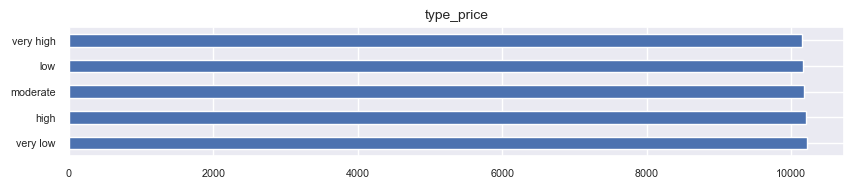

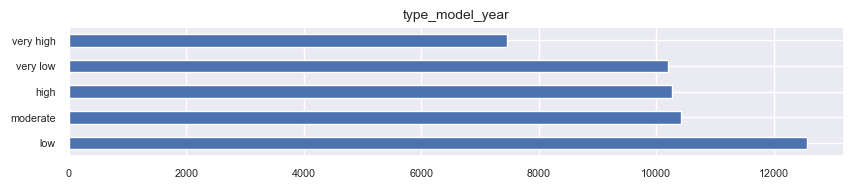

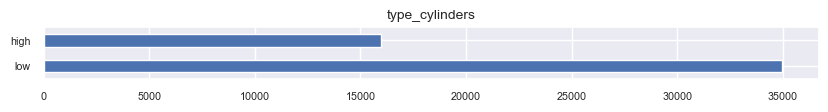

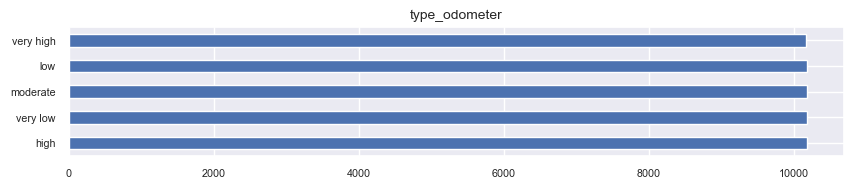

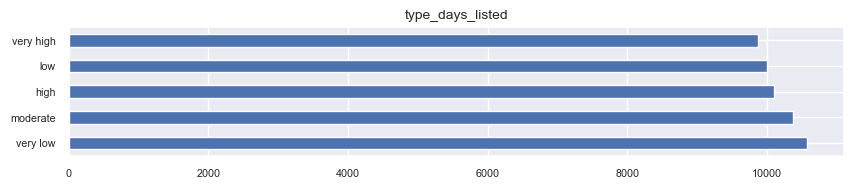

{'numeric_features': ['price',
  'model_year',
  'cylinders',
  'odometer',
  'days_listed'],
 'continuous_features': ['price', 'odometer'],
 'discrete_features': ['model_year', 'cylinders', 'days_listed'],
 'categorical_features': ['model',
  'condition',
  'type',
  'paint_color',
  'type_price',
  'type_model_year',
  'type_cylinders',
  'type_odometer',
  'type_days_listed'],
 'object_features': [],
 'bool_features': ['is_4wd'],
 'date_time_features': ['date_posted'],
 'time_delta_features': []}

,price,model_year,model,condition,cylinders,odometer,type,paint_color,is_4wd,date_posted,days_listed,type_price,type_model_year,type_cylinders,type_odometer,type_days_listed
0,9400.0,2011,bmw x5,good,6,145000.0,SUV,white,True,2018-06-23,19,moderate,moderate,low,high,low
1,25500.0,2011,ford f-150,good,6,88705.0,pickup,white,True,2018-10-19,50,very high,moderate,low,low,high
2,5500.0,2013,hyundai sonata,like new,4,110000.0,sedan,red,False,2019-02-07,79,low,high,low,moderate,very high
3,1500.0,2003,ford f-150,fair,8,113918.5,pickup,white,False,2019-03-22,9,very low,very low,high,moderate,very low
4,14900.0,2017,chrysler 200,excellent,4,80903.0,sedan,black,False,2019-04-02,28,high,very high,low,low,moderate


In [36]:
types_2 = ['low', 'high']
types_3 = ['low', 'normal', 'high']
types_5 = ['very low', 'low', 'moderate', 'high', 'very high']

# Columns created are added to delete later.
type_columns = [
    ('type_price', 'price', types_5),
    ('type_model_year', 'model_year', types_5),
    ('type_cylinders', 'cylinders', types_2),
    ('type_odometer', 'odometer', types_5),
    ('type_days_listed', 'days_listed', types_5)
]

for col in type_columns:
    plt.rcParams['figure.figsize'] = (10, len(col[2])/3)

    df[col[0]] = pd.qcut(x=df[col[1]], q=len(col[2]), labels=col[2])
#     df[col[0]] = pd.cut(x=df[col[1]], bins=len(col[2]), labels=col[2])

    df[col[0]].value_counts().plot(kind='barh')
    plt.title(col[0], fontsize=10)
    plt.show()

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

df.head()

In [37]:
date_columns = []

for col in date_time_features:
    dw, d, m = f'{col}_day_of_week', f'{col}_day', f'{col}_month'
    date_columns = date_columns + [dw, d, m]

    df[dw] = pd.DatetimeIndex(df[col]).dayofweek.astype('category')
    df[d] = pd.DatetimeIndex(df[col]).day.astype('category')
    df[m] = pd.DatetimeIndex(df[col]).month.astype('category')

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

df.head()

{'numeric_features': ['price',
  'model_year',
  'cylinders',
  'odometer',
  'days_listed'],
 'continuous_features': ['price', 'odometer'],
 'discrete_features': ['model_year', 'cylinders', 'days_listed'],
 'categorical_features': ['model',
  'condition',
  'type',
  'paint_color',
  'type_price',
  'type_model_year',
  'type_cylinders',
  'type_odometer',
  'type_days_listed',
  'date_posted_day_of_week',
  'date_posted_day',
  'date_posted_month'],
 'object_features': [],
 'bool_features': ['is_4wd'],
 'date_time_features': ['date_posted'],
 'time_delta_features': []}

,price,model_year,model,condition,cylinders,odometer,type,paint_color,is_4wd,date_posted,days_listed,type_price,type_model_year,type_cylinders,type_odometer,type_days_listed,date_posted_day_of_week,date_posted_day,date_posted_month
0,9400.0,2011,bmw x5,good,6,145000.0,SUV,white,True,2018-06-23,19,moderate,moderate,low,high,low,5,23,6
1,25500.0,2011,ford f-150,good,6,88705.0,pickup,white,True,2018-10-19,50,very high,moderate,low,low,high,4,19,10
2,5500.0,2013,hyundai sonata,like new,4,110000.0,sedan,red,False,2019-02-07,79,low,high,low,moderate,very high,3,7,2
3,1500.0,2003,ford f-150,fair,8,113918.5,pickup,white,False,2019-03-22,9,very low,very low,high,moderate,very low,4,22,3
4,14900.0,2017,chrysler 200,excellent,4,80903.0,sedan,black,False,2019-04-02,28,high,very high,low,low,moderate,1,2,4


Se pueden generar los principales gráficos en la carpeta `EDA` para luego analizarlos.

In [38]:
# %%script echo Comentar para ejecutar la celda

# El multihilo no funciona más rápido y tiene problemas al pintar los gráficos.

# False: Calcula la cantidad de imágenes aproximadas que se generarán.
# True: Genera las imágenes.
paint = False

count = 0

print(f'Step 01: {count} generated graphs.')

for i, x in enumerate(numeric_features):
    for j, y in enumerate(numeric_features):
        if j <= i:
            continue

        for hue in [None] + categorical_features + bool_features:
            if hue in [f'type_{x}', f'type_{y}']:
                continue

            if paint == True:
                my_relplot(x, y, hue, size=None, style=None, alpha=1,
                           show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 02: {count} generated graphs.')

for x in numeric_features:
    for y in categorical_features + bool_features:
        for hue in [None] + categorical_features + bool_features:

            if f'type_{x}' in [y, hue] or y == hue:
                continue

            if paint == True:
                my_swarmplot(x, y, hue, orient='v', n_samples=1000,
                             show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 03: {count} generated graphs.')

if paint == True:
    my_pearson(show=False, file_name=str(count).zfill(5))
    count += 1

print(f'Step 04: {count} generated graphs.')

for col in numeric_features:
    if paint == True:
        my_histplot(col, normal=False, stat='count', cumulative=False, hue=None, kde=False,
                    show=False, file_name=str(count).zfill(5))

    count += 1

print(f'Step 05: {count} generated graphs.')

for col in [None] + numeric_features:
    for violin in [False, True]:
        if paint == True:
            my_boxplot(col, violin, orient='v', show=False,
                       file_name=str(count).zfill(5))

        count += 1

print(f'Step 06: {count} generated graphs.')

for x in categorical_features + bool_features:
    for y in numeric_features:
        for hue in [None] + bool_features:
            if paint == True:
                my_violinplot(x, y, hue, violin=False, split=False, orient='v', show_points=False,
                              show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 07: {count} generated graphs.')

for i, index in enumerate(categorical_features + bool_features):
    for j, columns in enumerate(categorical_features + bool_features):
        if j <= i:
            continue

        # Para my_contingency con agg_func='count' se obtienen los mismos resultados sin importar el values seleccionado.
        if paint == True:
            my_contingency(index, columns, values=numeric_features[0], annot=True, agg_func='count',
                           show=False, file_name=str(count).zfill(5))

        count += 1

        for k, values in enumerate(numeric_features):
            if paint == True:
                my_contingency(index, columns, values, annot=True, agg_func='mean',
                               show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 08: {count} generated graphs.')

for x in categorical_features + bool_features:
    for y in numeric_features:
        for hue in [None] + categorical_features + bool_features:
            if f'type_{y}' in [x, hue] or x == hue:
                continue

            if paint == True:
                my_catplot(x, y, hue, estimator='mean', kind='bar', orient='v',
                           show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 09: {count} generated graphs.')

for col in categorical_features:
    if paint == True:
        my_pie(col, show=False, file_name=str(count).zfill(5))

    count += 1

print(f'Step 10: {count} generated graphs.')

for x in date_time_features:
    if len(numeric_features) > 0:
        y = numeric_features[0]

        for hue in [None] + categorical_features + bool_features:
            if paint == True:
                my_lineplot(x, y, agg_func='count', hue=hue, style=False,
                            show=False, file_name=str(count).zfill(5))

            count += 1

    for y in numeric_features:
        for hue in [None] + categorical_features + bool_features:
            if paint == True:
                my_lineplot(x, y, agg_func='mean', hue=hue, style=False,
                            show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 11: {count} generated graphs.')

Step 01: 0 generated graphs.
Step 02: 120 generated graphs.
Step 03: 840 generated graphs.
Step 04: 840 generated graphs.
Step 05: 845 generated graphs.
Step 06: 857 generated graphs.
Step 07: 987 generated graphs.
Step 08: 1455 generated graphs.
Step 09: 2175 generated graphs.
Step 10: 2187 generated graphs.
Step 11: 2271 generated graphs.


- Se debe ejecutar nuevamente las celdas del apartado `Data Visualization` para que se actualicen las columnas del dataset luego de su limpieza en el apartado `Data Cleaning`.
- `Data Visualization` se encuentra primero que `Data Cleaning` para que éste último sustente sus cambios a partir del gráfico generado con los valores sin limpiar.
- Se obtendrán conclusiones de los diferentes gráficos.

- Conclusión 1.
- Conclusión 2.
- Conclusión 3.
- Conclusión 4.
- Conclusión 5.

Se eliminan las columnas categóricas creadas anteriormente.

In [39]:
df.drop(labels=[t[0] for t in type_columns], axis=1, inplace=True)
df.drop(labels=date_columns, axis=1, inplace=True)

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

{'numeric_features': ['price',
  'model_year',
  'cylinders',
  'odometer',
  'days_listed'],
 'continuous_features': ['price', 'odometer'],
 'discrete_features': ['model_year', 'cylinders', 'days_listed'],
 'categorical_features': ['model', 'condition', 'type', 'paint_color'],
 'object_features': [],
 'bool_features': ['is_4wd'],
 'date_time_features': ['date_posted'],
 'time_delta_features': []}

# Machine Learning

## Preprocess

- Se crea el `preprocess` para las variables independientes.
- Se toma en cuenta el análisis de la distribución de las variables numéricas para decidir la estrategia de imputación `[median, mean, most_frequent]`.

Para evitar el siguiente error: `SimpleImputer does not support data with dtype bool`.

In [40]:
bool_col = df.select_dtypes(include=bool).columns
df[bool_col] = df[bool_col].astype('category')

In [41]:
preprocessor_resume = pd.DataFrame(data=df.dtypes, columns=['TYPE'])
preprocessor_resume['VALUES'] = preprocessor_resume.apply(lambda x: df[x.name].unique(),
                                                          axis=1)
preprocessor_resume['VALUES_LEN'] = preprocessor_resume.apply(lambda x: len(df[x.name].unique()),
                                                              axis=1)
preprocessor_resume[['IMPUTER', 'TRANSFORMER', 'STATE']] = 'UNKNOWN'

# ------------------------------------------------------------------------------------------------------------------

preprocessor_resume.loc[[], ['IMPUTER']] = 'Mean'
preprocessor_resume.loc[['days_listed', 'odometer', 'model_year'],
                        ['IMPUTER']] = 'Median'
preprocessor_resume.loc[['type', 'cylinders', 'model', 'condition', 'paint_color'],
                        ['IMPUTER']] = 'Mode'
preprocessor_resume.loc[['is_4wd'], ['IMPUTER']] = False

# ------------------------------------------------------------------------------------------------------------------

preprocessor_resume.loc[['model_year', 'cylinders', 'odometer', 'days_listed'],
                        ['TRANSFORMER']] = 'STANDARD_SCALER'
preprocessor_resume.loc[['model', 'type', 'paint_color', 'is_4wd'],
                        ['TRANSFORMER']] = 'ONE_HOT_ENCODER'
preprocessor_resume.loc[['condition'],
                        ['TRANSFORMER']] = 'ORDINAL_ENCODER'

# ------------------------------------------------------------------------------------------------------------------

median_standard_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('transformer', StandardScaler())])

mode_standard_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                      ('transformer', StandardScaler())])

mode_one_hot_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                     ('transformer', OneHotEncoder(sparse_output=True, drop='first'))])

condition_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('transformer', OrdinalEncoder(categories=[['new', 'like new', 'excellent',
                                                                              'good', 'fair', 'salvage']]))])

is_4wd_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=False)),
                               ('transformer', OneHotEncoder(sparse_output=True, drop='first'))])


median_standard_feat = preprocessor_resume.query(
    'IMPUTER == "Median" and TRANSFORMER == "STANDARD_SCALER"').index.to_list()

mode_standard_feat = preprocessor_resume.query(
    'IMPUTER == "Mode" and TRANSFORMER == "STANDARD_SCALER"').index.to_list()

mode_one_hot_feat = preprocessor_resume.query(
    'IMPUTER == "Mode" and TRANSFORMER == "ONE_HOT_ENCODER"').index.to_list()


preprocessor_resume.loc[median_standard_feat +
                        mode_standard_feat +
                        mode_one_hot_feat +
                        ['condition', 'is_4wd'], ['STATE']] = 'OK'

preprocessor = ColumnTransformer(transformers=[('median_standard',
                                                median_standard_trans, median_standard_feat),
                                               ('mode_standard',
                                                mode_standard_trans, mode_standard_feat),
                                               ('mode_one_hot',
                                                mode_one_hot_trans, mode_one_hot_feat),
                                               ('condition',
                                                condition_trans, ['condition']),
                                               ('is_4wd',
                                                is_4wd_trans, ['is_4wd'])])

# ------------------------------------------------------------------------------------------------------------------

display(preprocessor)
display(preprocessor_resume)

X = preprocessor.fit_transform(X=df)
print(f'Dimensiones de los datos: {X.shape}.')
del X

ColumnTransformer(transformers=[('median_standard',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('transformer',
                                                  StandardScaler())]),
                                 ['model_year', 'odometer', 'days_listed']),
                                ('mode_standard',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('transformer',
                                                  StandardScaler())]),
                                 ['cylinders']),
                                ('mode_one_hot',
                                 Pipeline(st...
                                 ['model', 'type', 'paint_color']),
                                ('condition',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('transformer',
                                                  OrdinalEncoder(categories=[['new',
                                                                              'like '
                                                                              'new',
                                                                              'excellent',
                                                                              'good',
                                                                              'fair',
                                                                              'salvage']]))]),
                                 ['condition']),
                                ('is_4wd',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant')),
                                                 ('transformer',
                                                  OneHotEncoder(drop='first'))]),
                                 ['is_4wd'])])

,TYPE,VALUES,VALUES_LEN,IMPUTER,TRANSFORMER,STATE
price,float64,"[9400.0, 25500.0, 5500.0, 1500.0, 14900.0, 149...",3217,UNKNOWN,UNKNOWN,UNKNOWN
model_year,int32,"[2011, 2013, 2003, 2017, 2014, 2015, 2012, 200...",67,Median,STANDARD_SCALER,OK
model,category,"['bmw x5', 'ford f-150', 'hyundai sonata', 'ch...",100,Mode,ONE_HOT_ENCODER,OK
condition,category,"['good', 'like new', 'fair', 'excellent', 'sal...",6,Mode,ORDINAL_ENCODER,OK
cylinders,int32,"[6, 4, 8, 5, 10, 3, 12]",7,Mode,STANDARD_SCALER,OK
odometer,float64,"[145000.0, 88705.0, 110000.0, 113918.5, 80903....",17549,Median,STANDARD_SCALER,OK
type,category,"['SUV', 'pickup', 'sedan', 'truck', 'coupe', ....",13,Mode,ONE_HOT_ENCODER,OK
paint_color,category,"['white', 'red', 'black', 'blue', 'grey', ...,...",12,Mode,ONE_HOT_ENCODER,OK
is_4wd,category,"[True, False] Categories (2, bool): [False, True]",2,False,ONE_HOT_ENCODER,OK
date_posted,datetime64[ns],"[2018-06-23T00:00:00.000000000, 2018-10-19T00:...",354,UNKNOWN,UNKNOWN,UNKNOWN


Dimensiones de los datos: (50906, 128).


Se defnine el `target`.

In [42]:
targets = df[target_column]
targets.shape

(50906,)

## Cross Validation

In [43]:
results = pd.DataFrame(
    columns=['NAME', 'TYPE', 'POLY_DEGREE', 'SCORE', 'ESTIMATOR'])


def my_grid_search_cv(model, X, y, results, param_grid, poly_degrees):
    estimators = []

    for degree in poly_degrees:
        steps = [('preprocessor', preprocessor),
                 ('polynomial', PolynomialFeatures(degree=degree)),
                 ('model', model)]

        pipe = Pipeline(steps=steps)

        target_transformer = MinMaxScaler(feature_range=(0, 1))
        sklearn_estimator = TransformedTargetRegressor(regressor=pipe,
                                                       transformer=target_transformer)

        grid_search = GridSearchCV(estimator=sklearn_estimator, param_grid=param_grid,
                                   scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, return_train_score=True)
        grid_search.fit(X, y)
        estimator = grid_search.best_estimator_
        estimators.append(estimator)

        score = round(grid_search.best_score_, 4)
        display(estimator)
        print(
            f'The model {str(model)} has a prediction error of +-{-score} dollars.')

        new_df = pd.DataFrame(data={'NAME': [str(model)], 'TYPE': 'ML', 'POLY_DEGREE': degree,
                                    'SCORE': [score], 'ESTIMATOR': [estimator]})
        results = pd.concat([results, new_df], ignore_index=True)

    return (results,) + tuple(estimators)

## Linear Regression

In [44]:
results, ols = my_grid_search_cv(model=LinearRegression(), X=df, y=targets, results=results,
                                 param_grid={}, poly_degrees=[1])
results

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('median_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('transformer',
                                                                                                        StandardScaler())]),
                                                                                       ['model_year',
                                                                                        'odometer',
                                                                                        'days_listed']),
                                                                                      ('mode_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('transf...
                                                                                                        OrdinalEncoder(categories=[['new',
                                                                                                                                    'like '
                                                                                                                                    'new',
                                                                                                                                    'excellent',
                                                                                                                                    'good',
                                                                                                                                    'fair',
                                                                                                                                    'salvage']]))]),
                                                                                       ['condition']),
                                                                                      ('is_4wd',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(fill_value=False,
                                                                                                                      strategy='constant')),
                                                                                                       ('transformer',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['is_4wd'])])),
                                                     ('polynomial',
                                                      PolynomialFeatures(degree=1)),
                                                     ('model',
                                                      LinearRegression())]),
                           transformer=MinMaxScaler())

The model LinearRegression() has a prediction error of +-3560.6001 dollars.


,NAME,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
0,LinearRegression(),ML,1,-3560.6001,TransformedTargetRegressor(regressor=Pipeline(...


## Regularization

### Lasso

In [45]:
param_grid = {'regressor__model__alpha': np.linspace(0.1, 1.0, 10)}
results, lasso = my_grid_search_cv(model=Lasso(), X=df, y=targets, results=results,
                                   param_grid=param_grid, poly_degrees=[1])
results

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('median_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('transformer',
                                                                                                        StandardScaler())]),
                                                                                       ['model_year',
                                                                                        'odometer',
                                                                                        'days_listed']),
                                                                                      ('mode_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('transf...
                                                                                                        OrdinalEncoder(categories=[['new',
                                                                                                                                    'like '
                                                                                                                                    'new',
                                                                                                                                    'excellent',
                                                                                                                                    'good',
                                                                                                                                    'fair',
                                                                                                                                    'salvage']]))]),
                                                                                       ['condition']),
                                                                                      ('is_4wd',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(fill_value=False,
                                                                                                                      strategy='constant')),
                                                                                                       ('transformer',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['is_4wd'])])),
                                                     ('polynomial',
                                                      PolynomialFeatures(degree=1)),
                                                     ('model',
                                                      Lasso(alpha=0.1))]),
                           transformer=MinMaxScaler())

The model Lasso() has a prediction error of +-6874.2472 dollars.


,NAME,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
0,LinearRegression(),ML,1,-3560.6001,TransformedTargetRegressor(regressor=Pipeline(...
1,Lasso(),ML,1,-6874.2472,TransformedTargetRegressor(regressor=Pipeline(...


### Ridge

In [46]:
param_grid = {'regressor__model__alpha': np.linspace(0.1, 1.0, 10)}
results, ridge = my_grid_search_cv(model=Ridge(), X=df, y=targets, results=results,
                                   param_grid=param_grid, poly_degrees=[1])
results

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('median_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('transformer',
                                                                                                        StandardScaler())]),
                                                                                       ['model_year',
                                                                                        'odometer',
                                                                                        'days_listed']),
                                                                                      ('mode_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('transf...
                                                                                                        OrdinalEncoder(categories=[['new',
                                                                                                                                    'like '
                                                                                                                                    'new',
                                                                                                                                    'excellent',
                                                                                                                                    'good',
                                                                                                                                    'fair',
                                                                                                                                    'salvage']]))]),
                                                                                       ['condition']),
                                                                                      ('is_4wd',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(fill_value=False,
                                                                                                                      strategy='constant')),
                                                                                                       ('transformer',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['is_4wd'])])),
                                                     ('polynomial',
                                                      PolynomialFeatures(degree=1)),
                                                     ('model',
                                                      Ridge(alpha=0.30000000000000004))]),
                           transformer=MinMaxScaler())

The model Ridge() has a prediction error of +-3560.3693 dollars.


,NAME,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
0,LinearRegression(),ML,1,-3560.6001,TransformedTargetRegressor(regressor=Pipeline(...
1,Lasso(),ML,1,-6874.2472,TransformedTargetRegressor(regressor=Pipeline(...
2,Ridge(),ML,1,-3560.3693,TransformedTargetRegressor(regressor=Pipeline(...


### ElasticNet

In [47]:
param_grid = {'regressor__model__alpha': np.linspace(0.1, 1.0, 10)}
results, elastic_net = my_grid_search_cv(model=ElasticNet(), X=df, y=targets, results=results,
                                         param_grid=param_grid, poly_degrees=[1])
results

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('median_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('transformer',
                                                                                                        StandardScaler())]),
                                                                                       ['model_year',
                                                                                        'odometer',
                                                                                        'days_listed']),
                                                                                      ('mode_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('transf...
                                                                                                        OrdinalEncoder(categories=[['new',
                                                                                                                                    'like '
                                                                                                                                    'new',
                                                                                                                                    'excellent',
                                                                                                                                    'good',
                                                                                                                                    'fair',
                                                                                                                                    'salvage']]))]),
                                                                                       ['condition']),
                                                                                      ('is_4wd',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(fill_value=False,
                                                                                                                      strategy='constant')),
                                                                                                       ('transformer',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['is_4wd'])])),
                                                     ('polynomial',
                                                      PolynomialFeatures(degree=1)),
                                                     ('model',
                                                      ElasticNet(alpha=0.1))]),
                           transformer=MinMaxScaler())

The model ElasticNet() has a prediction error of +-5965.0075 dollars.


,NAME,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
0,LinearRegression(),ML,1,-3560.6001,TransformedTargetRegressor(regressor=Pipeline(...
1,Lasso(),ML,1,-6874.2472,TransformedTargetRegressor(regressor=Pipeline(...
2,Ridge(),ML,1,-3560.3693,TransformedTargetRegressor(regressor=Pipeline(...
3,ElasticNet(),ML,1,-5965.0075,TransformedTargetRegressor(regressor=Pipeline(...


## Decision Trees

In [48]:
# param_grid = {'regressor__model__max_depth': range(1, 20),
#               'regressor__model__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']}
# results, decision_tree_regressor = my_grid_search_cv(model=DecisionTreeRegressor(), X=df, y=targets,
#                                                      results=results, param_grid=param_grid, poly_degrees=[1])
# results

## Support Vector Machines (SVM)

In [49]:
# param_grid = {'regressor__model__kernel': ['linear', 'poly', 'sigmoid', 'rbf'],  # Allows transformation to higher levels.
#               # Border complexity: linear, curved.
#               'regressor__model__gamma': [1e-3, 1e-2, 0.1],
#               'regressor__model__C': [1, 10, 100]}          # Controls the tradeoff between training errors and hard margins.
# results, svr = my_grid_search_cv(model=SVR(), X=df, y=targets, results=results,
#                                  param_grid=param_grid, poly_degrees=[1])
# results

## K Nearest Neighbors

In [50]:
# param_grid = {'regressor__model__n_neighbors': range(3, 20, 2),
#               'regressor__model__metric': ['euclidean', 'manhattan', 'chebyshev']}
# results, k_neighbors_regressor = my_grid_search_cv(model=KNeighborsRegressor(), X=df, y=targets, results=results,
#                                                    param_grid=param_grid, poly_degrees=[1])
# results

## Naive Bayes

In [51]:
# results, bayesian_ridge = my_grid_search_cv(model=BayesianRidge(), X=df, y=targets, results=results,
#                                             param_grid={}, poly_degrees=[1])
# results

## Ensemble Methods

### Bagging

In [52]:
# param_grid = {'regressor__model__base_estimator': [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(),
#                                                    SVR(), KNeighborsRegressor(), BayesianRidge()],
#               'regressor__model__n_estimators': range(1, 21)}
# results, bagging_regressor = my_grid_search_cv(model=BaggingRegressor(), X=df, y=targets, results=results,
#                                                param_grid=param_grid, poly_degrees=[1])
# results

### Boosting

In [53]:
# param_grid = {'regressor__model__base_estimator': [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(),
#                                                    SVR(), KNeighborsRegressor(), BayesianRidge()],
#               'regressor__model__n_estimators': range(1, 21)}
# results, bagging_regressor = my_grid_search_cv(model=AdaBoostRegressor(), X=df, y=targets, results=results,
#                                                param_grid=param_grid, poly_degrees=[1])
# results

### Gradient Boosting (GBRT)

In [54]:
# param_grid = {'regressor__model__n_estimators': range(1, 21)}
# results, gradient_boosting_regressor = my_grid_search_cv(model=GradientBoostingRegressor(), X=df, y=targets,
#                                                          results=results, param_grid=param_grid, poly_degrees=[1])
# results

### Random Forests

In [55]:
# param_grid = {'regressor__model__n_estimators': range(1, 21)}
# results, random_forest_regressor = my_grid_search_cv(model=RandomForestRegressor(), X=df, y=targets,
#                                                      results=results, param_grid=param_grid, poly_degrees=[1])
# results

## Learning Curves

In [56]:
train_sizes, train_scores, test_scores = learning_curve(ols, df, targets, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error',
                                                        train_sizes=np.linspace(0.01, 1., 10))
train_sizes.shape, train_scores.shape, test_scores.shape

((10,), (10, 5), (10, 5))

In [57]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean

array([-2761.92468269, -3448.60719185, -3481.19149564, -3615.00377404,
       -3653.10418814, -3617.7396251 , -3581.00052742, -3576.5807783 ,
       -3549.17108024, -3526.63437297])

In [58]:
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean

array([           nan, -3746.83673822, -3633.75394591, -3628.44364756,
       -3636.94818768, -3611.37803915, -3593.07135653, -3583.1684396 ,
       -3573.25883186, -3564.12081688])

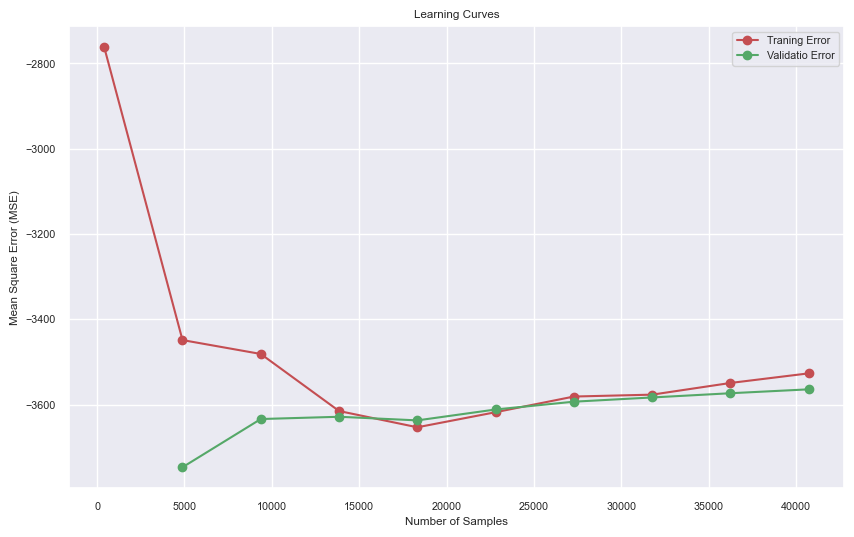

In [59]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.rc('figure', figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-',
         color='r', label='Traning Error')
plt.plot(train_sizes, test_scores_mean, 'o-',
         color='g', label='Validatio Error')

plt.title('Learning Curves')
plt.xlabel('Number of Samples')
plt.ylabel('Mean Square Error (MSE)')

plt.legend()

Shortcode for all estimators.

In [60]:
results_model_key = results.copy()
results_model_key.set_index('NAME', inplace=True)


@interact(model=results_model_key.index)
def _(model):
    plt.rc('figure', figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(results_model_key.loc[model].ESTIMATOR, df, targets, cv=5,
                                                            n_jobs=-1, train_sizes=np.linspace(0.01, 1., 10),
                                                            scoring='neg_mean_absolute_error')

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-',
             color='r', label='Traning error')
    plt.plot(train_sizes, test_scores_mean, 'o-',
             color='g', label='Validatio error')

    plt.title(f'Learning Curves: {model}')
    plt.xlabel('Number of Samples')
    plt.ylabel('Mean Square Error (MSE)')

    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='model', options=('LinearRegression()', 'Lasso()', 'Ridge()', 'Elas…

## Validation Curves

Los hiperparámetros ya fueron seleccionados en cada uno de los algoritmos mediante `GridSearchCV`.

# Deep Learning

Cuda version.

In [61]:
print(f'Tensorflow version: {tf.__version__}')
print(f"Cuda version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")

Tensorflow version: 2.6.0
Cuda version: 64_113
Cudnn version: 64_8


**Enable GPU**

- The environment must be created with a version of Python compatible with the operation of Tensorflow and its use of the GPU (https://www.tensorflow.org/install/pip#virtual-environment-install).
- Before installing tensorflow-gpu you must install CUDA Toolkit and cuDNN from official NVIDIA site.
- Anaconda must be restarted after installing tensorflow-gpu.

In [62]:
# !conda install -y tensorflow-gpu keras-gpu

if len(tf.config.list_physical_devices('GPU')) == 0:
    raise SystemExit('Restart Anaconda to activate the GPU.')
else:
    print('GPU activated.')

GPU activated.


Available hardware.

In [63]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available hardware details.

In [64]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1150715535600089374,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2236245607
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16655126039044606630
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

## Tensorboard

In [65]:
# !rm -rf logs/

In [66]:
# %load_ext tensorboard
# %tensorboard --logdir logs

# if error: eliminar .tensorboard-info en C:\Users\%username%\AppData\Local\Temp

In [67]:
tensorboard = TensorBoard(os.path.join('logs', datetime.now().strftime('%Y%m%d-%H%M%S')), histogram_freq=1,
                          write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)

## Preprocess

Data for neural networks is mostly normalized data, not standardized.

In [68]:
preprocessor_resume[['IMPUTER', 'TRANSFORMER', 'STATE']] = 'UNKNOWN'

# ------------------------------------------------------------------------------------------------------------------

preprocessor_resume.loc[[], ['IMPUTER']] = 'Mean'
preprocessor_resume.loc[['days_listed', 'odometer', 'model_year'],
                        ['IMPUTER']] = 'Median'
preprocessor_resume.loc[['type', 'cylinders', 'model', 'condition', 'paint_color'],
                        ['IMPUTER']] = 'Mode'
preprocessor_resume.loc[['is_4wd'], ['IMPUTER']] = False

# ------------------------------------------------------------------------------------------------------------------

preprocessor_resume.loc[['model_year', 'cylinders', 'odometer', 'days_listed'],
                        ['TRANSFORMER']] = 'MIX_MAX_SCALER'
preprocessor_resume.loc[['model', 'type', 'paint_color', 'is_4wd'],
                        ['TRANSFORMER']] = 'ONE_HOT_ENCODER'
preprocessor_resume.loc[['condition'],
                        ['TRANSFORMER']] = 'ORDINAL_ENCODER'

# ------------------------------------------------------------------------------------------------------------------

median_mix_max_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                       ('transformer', MinMaxScaler())])

mode_mix_max_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                     ('transformer', MinMaxScaler())])

mode_one_hot_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                     ('transformer', OneHotEncoder(sparse_output=False, drop='first'))])

condition_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('transformer', OrdinalEncoder(categories=[['new', 'like new', 'excellent',
                                                                              'good', 'fair', 'salvage']]))])

is_4wd_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=False)),
                               ('transformer', OneHotEncoder(sparse_output=False, drop='first'))])


median_mix_max_feat = preprocessor_resume.query(
    'IMPUTER == "Median" and TRANSFORMER == "MIX_MAX_SCALER"').index.to_list()

mode_mix_max_feat = preprocessor_resume.query(
    'IMPUTER == "Mode" and TRANSFORMER == "MIX_MAX_SCALER"').index.to_list()

mode_one_hot_feat = preprocessor_resume.query(
    'IMPUTER == "Mode" and TRANSFORMER == "ONE_HOT_ENCODER"').index.to_list()


preprocessor_resume.loc[median_mix_max_feat +
                        mode_mix_max_feat +
                        mode_one_hot_feat +
                        ['condition', 'is_4wd'], ['STATE']] = 'OK'

preprocessor = ColumnTransformer(transformers=[('median_mix_max',
                                                median_mix_max_trans, median_mix_max_feat),
                                               ('mode_mix_max',
                                                mode_mix_max_trans, mode_mix_max_feat),
                                               ('mode_one_hot',
                                                mode_one_hot_trans, mode_one_hot_feat),
                                               ('condition',
                                                condition_trans, ['condition']),
                                               ('is_4wd',
                                                is_4wd_trans, ['is_4wd'])])

# ------------------------------------------------------------------------------------------------------------------

display(preprocessor)
display(preprocessor_resume)

X = preprocessor.fit_transform(X=df)
print(f'Dimensiones de los datos: {X.shape}.')
input_dim = X.shape[1]
del X

ColumnTransformer(transformers=[('median_mix_max',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('transformer',
                                                  MinMaxScaler())]),
                                 ['model_year', 'odometer', 'days_listed']),
                                ('mode_mix_max',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('transformer',
                                                  MinMaxScaler())]),
                                 ['cylinders']),
                                ('mode_one_hot',
                                 Pipeline(steps=[(...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('transformer',
                                                  OrdinalEncoder(categories=[['new',
                                                                              'like '
                                                                              'new',
                                                                              'excellent',
                                                                              'good',
                                                                              'fair',
                                                                              'salvage']]))]),
                                 ['condition']),
                                ('is_4wd',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant')),
                                                 ('transformer',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['is_4wd'])])

,TYPE,VALUES,VALUES_LEN,IMPUTER,TRANSFORMER,STATE
price,float64,"[9400.0, 25500.0, 5500.0, 1500.0, 14900.0, 149...",3217,UNKNOWN,UNKNOWN,UNKNOWN
model_year,int32,"[2011, 2013, 2003, 2017, 2014, 2015, 2012, 200...",67,Median,MIX_MAX_SCALER,OK
model,category,"['bmw x5', 'ford f-150', 'hyundai sonata', 'ch...",100,Mode,ONE_HOT_ENCODER,OK
condition,category,"['good', 'like new', 'fair', 'excellent', 'sal...",6,Mode,ORDINAL_ENCODER,OK
cylinders,int32,"[6, 4, 8, 5, 10, 3, 12]",7,Mode,MIX_MAX_SCALER,OK
odometer,float64,"[145000.0, 88705.0, 110000.0, 113918.5, 80903....",17549,Median,MIX_MAX_SCALER,OK
type,category,"['SUV', 'pickup', 'sedan', 'truck', 'coupe', ....",13,Mode,ONE_HOT_ENCODER,OK
paint_color,category,"['white', 'red', 'black', 'blue', 'grey', ...,...",12,Mode,ONE_HOT_ENCODER,OK
is_4wd,category,"[True, False] Categories (2, bool): [False, True]",2,False,ONE_HOT_ENCODER,OK
date_posted,datetime64[ns],"[2018-06-23T00:00:00.000000000, 2018-10-19T00:...",354,UNKNOWN,UNKNOWN,UNKNOWN


Dimensiones de los datos: (50906, 128).


## Keras - Multilayer Perceptron (MLP)

Training and test data are generated.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.2,
                                                    shuffle=True)

In [70]:
with tf.device('/GPU:0'):
    # Clear backend
    backend.clear_session()

    keras_model = Sequential([Dense(units=50, activation='relu', kernel_constraint=maxnorm(max_value=3),
                                    input_dim=input_dim),
                              Dropout(rate=0.2),

                              Dense(units=50, activation='relu',
                                    kernel_constraint=maxnorm(max_value=3)),
                              Dropout(rate=0.2),

                              Dense(units=1, activation='relu')])

    keras_model.compile(optimizer=RMSprop(),  # optimizer
                        loss='mse',           # función de pérdida o coste
                        metrics=['mae'])      # Metrics to observe the evolution of the model training

    display(keras_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 9,051
Trainable params: 9,051
Non-trainable params: 0
_________________________________________________________________


None

In [71]:
# Al no existir una estimador parecido a TransformedTargetRegressor para Keras, implementamos el nuestro.
# Esperar actualizaciones...

class MyTransformedTargetRegressor(BaseEstimator, TransformerMixin):
    def __init__(self, regressor, transformer):
        self.regressor = regressor
        self.transformer = transformer

    def fit(self, X, y, **kwargs):
        y = y.values
        y = y.reshape(-1, 1) if y.ndim == 1 else y
        y = self.transformer.fit_transform(y)

        self.regressor.fit(X, y, **kwargs)

        return self

    def predict(self, X, **kwargs):
        y = self.regressor.predict(X, **kwargs)
        y = y.reshape(-1, 1) if y.ndim == 1 else y
        y = self.transformer.inverse_transform(y)

        return y.squeeze()

    def save(self, path):
        if os.path.isdir(path) == False:
            os.mkdir(path)

        pickle.dump(self.regressor['preprocessor'],
                    open(f'{path}/preprocessor.pkl', 'wb'))

        self.regressor['model'].save(f'{path}/model.h5')

        pickle.dump(self.transformer,
                    open(f'{path}/transformer.pkl', 'wb'))

    @staticmethod
    def load(path):
        preprocessor = pickle.load(open(f'{path}/preprocessor.pkl', 'rb'))

        model = load_model(f'{path}/model.h5')

        transformer = pickle.load(
            open(f'{path}/transformer.pkl', 'rb'))

        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

        return MyTransformedTargetRegressor(regressor=pipe, transformer=transformer)

In [72]:
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', keras_model)])

target_transformer = MinMaxScaler(feature_range=(0, 1))

keras_estimator = MyTransformedTargetRegressor(regressor=pipe,
                                               transformer=target_transformer)

X_val = preprocessor.fit_transform(X=X_test)
y_test_re = np.reshape(y_test.values, (-1, 1))
y_val = target_transformer.fit_transform(y_test_re)

keras_estimator.fit(X_train, y_train, model__batch_size=64, model__epochs=10, model__verbose=1,
                    model__shuffle=True, model__callbacks=[],
                    model__validation_data=(X_val, y_val))

Epoch 1/10
637/637 [==============================] - 4s 5ms/step - loss: 0.0282 - mae: 0.1236 - val_loss: 0.0195 - val_mae: 0.1026
Epoch 2/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0193 - mae: 0.0983 - val_loss: 0.0163 - val_mae: 0.0889
Epoch 3/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0172 - mae: 0.0911 - val_loss: 0.0172 - val_mae: 0.0902
Epoch 4/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0163 - mae: 0.0879 - val_loss: 0.0149 - val_mae: 0.0839
Epoch 5/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0155 - mae: 0.0853 - val_loss: 0.0143 - val_mae: 0.0803
Epoch 6/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0150 - mae: 0.0835 - val_loss: 0.0141 - val_mae: 0.0804
Epoch 7/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0147 - mae: 0.0822 - val_loss: 0.0139 - val_mae: 0.0813
Epoch 8/10
637/637 [==============================] - 3s 4ms/step - loss: 0.

MyTransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                        ColumnTransformer(transformers=[('median_mix_max',
                                                                                         Pipeline(steps=[('imputer',
                                                                                                          SimpleImputer(strategy='median')),
                                                                                                         ('transformer',
                                                                                                          MinMaxScaler())]),
                                                                                         ['model_year',
                                                                                          'odometer',
                                                                                          'days_listed']),
                                                                                        ('mode_mix_max',
                                                                                         Pipeline(steps=[('imputer',
                                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                                         ('transfor...
                                                                                                          OrdinalEncoder(categories=[['new',
                                                                                                                                      'like '
                                                                                                                                      'new',
                                                                                                                                      'excellent',
                                                                                                                                      'good',
                                                                                                                                      'fair',
                                                                                                                                      'salvage']]))]),
                                                                                         ['condition']),
                                                                                        ('is_4wd',
                                                                                         Pipeline(steps=[('imputer',
                                                                                                          SimpleImputer(fill_value=False,
                                                                                                                        strategy='constant')),
                                                                                                         ('transformer',
                                                                                                          OneHotEncoder(drop='first',
                                                                                                                        sparse_output=False))]),
                                                                                         ['is_4wd'])])),
                                                       ('model',
                                                        <keras.engine.sequential.Sequential object at 0x000002B2886966D0>)]),
                             transformer=MinMaxScaler())

Analyzing the training and evaluation data.

In [73]:
keras_model = keras_estimator.regressor['model']

historial_train = keras_model.history
hist = pd.DataFrame(historial_train.history)
hist['epoch'] = historial_train.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
5,0.014980,0.083541,0.014096,0.080376,5
6,0.014730,0.082200,0.013932,0.081275,6
7,0.014172,0.080753,0.016981,0.092373,7
8,0.013854,0.079263,0.013408,0.077388,8
9,0.013556,0.078245,0.013159,0.076564,9


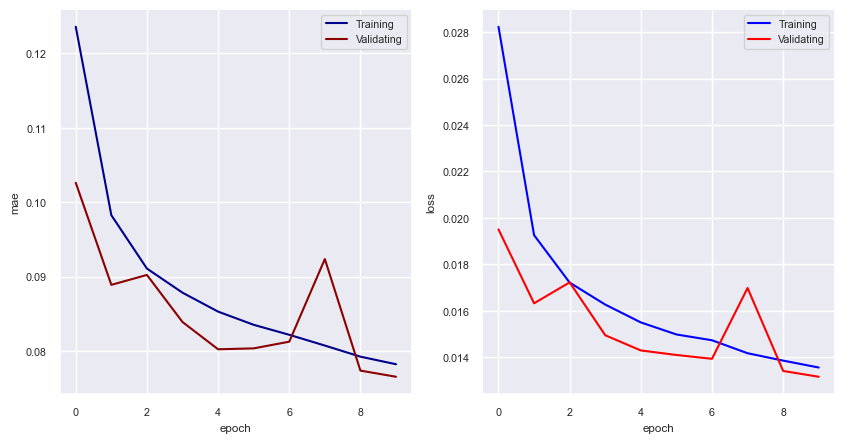

In [74]:
def plot_metrics(train):
    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('mae')
    ax1.plot(train.history['mae'], color='darkblue', label='Training')
    ax1.plot(train.history['val_mae'], color='darkred', label='Validating')
    ax1.legend()

    ax1 = plt.subplot(1, 2, 2)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(train.history['loss'], color='blue', label='Training')
    ax1.plot(train.history['val_loss'], color='red', label='Validating')
    ax1.legend()


plot_metrics(historial_train)

Model evaluation.

In [75]:
mae_train = mean_absolute_error(y_train, keras_estimator.predict(X=X_train))
mae_test = mean_absolute_error(y_test, keras_estimator.predict(X=X_test))

mae_train, mae_test = round(mae_train, 4), round(mae_test, 4)

print(f'\nMAE Train: {mae_train}')
print(f'MAE Test: {mae_test}')


MAE Train: 3048.2274
MAE Test: 3129.0197


In [76]:
keras_estimator

MyTransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                        ColumnTransformer(transformers=[('median_mix_max',
                                                                                         Pipeline(steps=[('imputer',
                                                                                                          SimpleImputer(strategy='median')),
                                                                                                         ('transformer',
                                                                                                          MinMaxScaler())]),
                                                                                         ['model_year',
                                                                                          'odometer',
                                                                                          'days_listed']),
                                                                                        ('mode_mix_max',
                                                                                         Pipeline(steps=[('imputer',
                                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                                         ('transfor...
                                                                                                          OrdinalEncoder(categories=[['new',
                                                                                                                                      'like '
                                                                                                                                      'new',
                                                                                                                                      'excellent',
                                                                                                                                      'good',
                                                                                                                                      'fair',
                                                                                                                                      'salvage']]))]),
                                                                                         ['condition']),
                                                                                        ('is_4wd',
                                                                                         Pipeline(steps=[('imputer',
                                                                                                          SimpleImputer(fill_value=False,
                                                                                                                        strategy='constant')),
                                                                                                         ('transformer',
                                                                                                          OneHotEncoder(drop='first',
                                                                                                                        sparse_output=False))]),
                                                                                         ['is_4wd'])])),
                                                       ('model',
                                                        <keras.engine.sequential.Sequential object at 0x000002B2886966D0>)]),
                             transformer=MinMaxScaler())

In [77]:
new_df = pd.DataFrame(data={'NAME': ['Keras (MLP)'], 'TYPE': 'DL', 'POLY_DEGREE': 0,
                            'SCORE': [-mae_test], 'ESTIMATOR': [keras_estimator]})
results = pd.concat([results, new_df], ignore_index=True)
results

,NAME,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
0,LinearRegression(),ML,1,-3560.6001,TransformedTargetRegressor(regressor=Pipeline(...
1,Lasso(),ML,1,-6874.2472,TransformedTargetRegressor(regressor=Pipeline(...
2,Ridge(),ML,1,-3560.3693,TransformedTargetRegressor(regressor=Pipeline(...
3,ElasticNet(),ML,1,-5965.0075,TransformedTargetRegressor(regressor=Pipeline(...
4,Keras (MLP),DL,0,-3129.0197,MyTransformedTargetRegressor(regressor=Pipelin...


# Resume

In [78]:
results_sort = results.sort_values(by=['SCORE'], ascending=[False])
results_sort

,NAME,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
4,Keras (MLP),DL,0,-3129.0197,MyTransformedTargetRegressor(regressor=Pipelin...
2,Ridge(),ML,1,-3560.3693,TransformedTargetRegressor(regressor=Pipeline(...
0,LinearRegression(),ML,1,-3560.6001,TransformedTargetRegressor(regressor=Pipeline(...
3,ElasticNet(),ML,1,-5965.0075,TransformedTargetRegressor(regressor=Pipeline(...
1,Lasso(),ML,1,-6874.2472,TransformedTargetRegressor(regressor=Pipeline(...


<AxesSubplot: ylabel='NAME'>

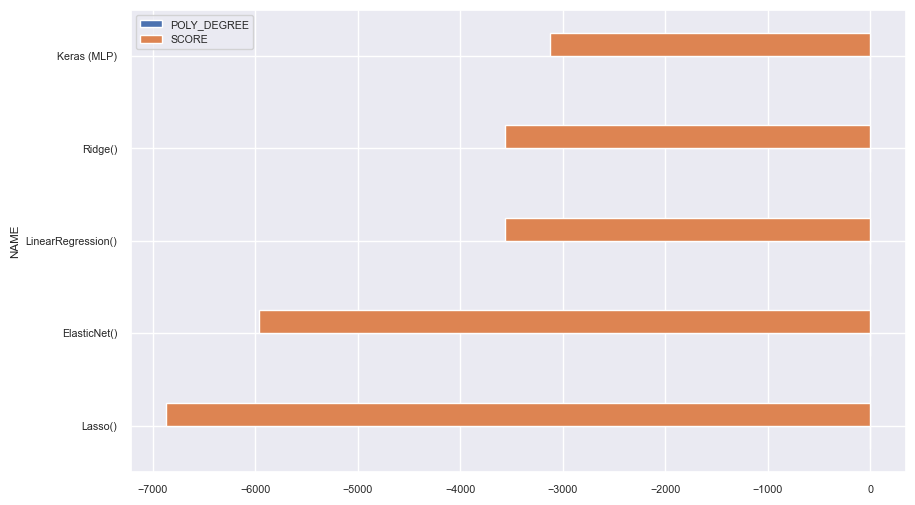

In [79]:
plt.rc('figure', figsize=(10, 6))
results_sort[::-1].set_index('NAME').plot.barh(rot=0)

In [80]:
print(
    f'Best tentative algorithm "{results_sort.iloc[0].NAME}" with SCORE={-results_sort.iloc[0].SCORE}.')

Best tentative algorithm "Keras (MLP)" with SCORE=3129.0197.


In [81]:
best_sklearn_model = results_sort[results_sort.TYPE == 'ML'].iloc[0].ESTIMATOR
best_keras_model = results_sort[results_sort.TYPE == 'DL'].iloc[0].ESTIMATOR

## Export

Save to file.

In [82]:
sklearn_model_filename = '_resources/0103_sklearn_model.pkl'
keras_model_folder = '_resources/0103_keras_model'

pickle.dump(best_sklearn_model, open(sklearn_model_filename, 'wb'))
best_keras_model.save(keras_model_folder)

Load from file.

In [83]:
sklearn_model_loaded = pickle.load(open(sklearn_model_filename, 'rb'))
keras_model_loaded = MyTransformedTargetRegressor.load(keras_model_folder)

display(sklearn_model_loaded, keras_model_loaded)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('median_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('transformer',
                                                                                                        StandardScaler())]),
                                                                                       ['model_year',
                                                                                        'odometer',
                                                                                        'days_listed']),
                                                                                      ('mode_standard',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('transf...
                                                                                                        OrdinalEncoder(categories=[['new',
                                                                                                                                    'like '
                                                                                                                                    'new',
                                                                                                                                    'excellent',
                                                                                                                                    'good',
                                                                                                                                    'fair',
                                                                                                                                    'salvage']]))]),
                                                                                       ['condition']),
                                                                                      ('is_4wd',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(fill_value=False,
                                                                                                                      strategy='constant')),
                                                                                                       ('transformer',
                                                                                                        OneHotEncoder(drop='first'))]),
                                                                                       ['is_4wd'])])),
                                                     ('polynomial',
                                                      PolynomialFeatures(degree=1)),
                                                     ('model',
                                                      Ridge(alpha=0.30000000000000004))]),
                           transformer=MinMaxScaler())

MyTransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                        ColumnTransformer(transformers=[('median_mix_max',
                                                                                         Pipeline(steps=[('imputer',
                                                                                                          SimpleImputer(strategy='median')),
                                                                                                         ('transformer',
                                                                                                          MinMaxScaler())]),
                                                                                         ['model_year',
                                                                                          'odometer',
                                                                                          'days_listed']),
                                                                                        ('mode_mix_max',
                                                                                         Pipeline(steps=[('imputer',
                                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                                         ('transfor...
                                                                                                          OrdinalEncoder(categories=[['new',
                                                                                                                                      'like '
                                                                                                                                      'new',
                                                                                                                                      'excellent',
                                                                                                                                      'good',
                                                                                                                                      'fair',
                                                                                                                                      'salvage']]))]),
                                                                                         ['condition']),
                                                                                        ('is_4wd',
                                                                                         Pipeline(steps=[('imputer',
                                                                                                          SimpleImputer(fill_value=False,
                                                                                                                        strategy='constant')),
                                                                                                         ('transformer',
                                                                                                          OneHotEncoder(drop='first',
                                                                                                                        sparse_output=False))]),
                                                                                         ['is_4wd'])])),
                                                       ('model',
                                                        <keras.engine.sequential.Sequential object at 0x000002B2ADA39D90>)]),
                             transformer=MinMaxScaler())

## Predict

In [86]:
_X = df.sample(20)

pred_df = pd.DataFrame(data={'REAL': _X[target_column],
                             'SKLEARN_PRED': sklearn_model_loaded.predict(X=_X),
                             'KERAS_PRED': keras_model_loaded.predict(X=_X)})

pred_df

,REAL,SKLEARN_PRED,KERAS_PRED
35531,26500.0,20294.048020,22764.369141
33625,21999.0,17569.378739,18754.921875
186,3000.0,4692.981823,5136.686035
22330,16490.0,17704.924066,12305.176758
7450,35600.0,31900.469026,28627.794922
20748,3500.0,6707.059475,4606.541016
4868,27957.0,20446.742309,21989.826172
16461,9999.0,8927.706777,7609.997070
40570,30000.0,23706.127701,26081.501953
14660,20999.0,22141.016163,24384.335938
